In [55]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster

In [56]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe'
]
linkage = 'ward'
metric = 'euclidean'

In [57]:


def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    region_hulls = gpd.read_parquet(
            regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
    )
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id)
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):

    ### primary chars
    region_hulls = gpd.read_parquet(
            regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
    )
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [84]:
def preprocess_data(data):
    component_data = data.drop(columns=['percentile_25', 'percentile_75', 'median', 'std'], level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = StandardScaler().fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data)

    return component_data

In [4]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [5]:
%%time

## generate and save linkage matricies for each region
for region_id, _ in region_hulls.iterrows():
    data = read_region_morphotope_data(region_id)
    linkage_matrix = get_morphotope_linkage(data)
    np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

### Setup regional cutoff to merge regional morphotopes

In [121]:
regional_cutoff = 15

In [122]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [123]:
%%time

## generate and save linkage matricies for each region
morphotopes_data = []
for region_id, _ in region_hulls.iterrows():
    data = read_region_morphotope_data(region_id)
    morphotopes_data.append(data)

morphotopes_data = pd.concat(morphotopes_data)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [387]:
### get mean of regional clusters, to continue building the tree
regional_ward_morphotopes_data = morphotopes_data.groupby(regional_clusters).mean().fillna(0)

In [95]:
# region_id = 4
# data = read_region_morphotope_data(region_id)
# linkage_matrix = get_morphotope_linkage(data)

### Final ward clustering

In [124]:

linkage = 'ward'
metric = 'euclidean'

In [125]:
%%time
# linkage_matrix = get_morphotope_linkage(preprocess_data(regional_ward_morphotopes_data))

linkage_matrix = get_morphotope_linkage(regional_ward_morphotopes_data)

CPU times: user 2min 26s, sys: 5.65 s, total: 2min 32s
Wall time: 2min 31s


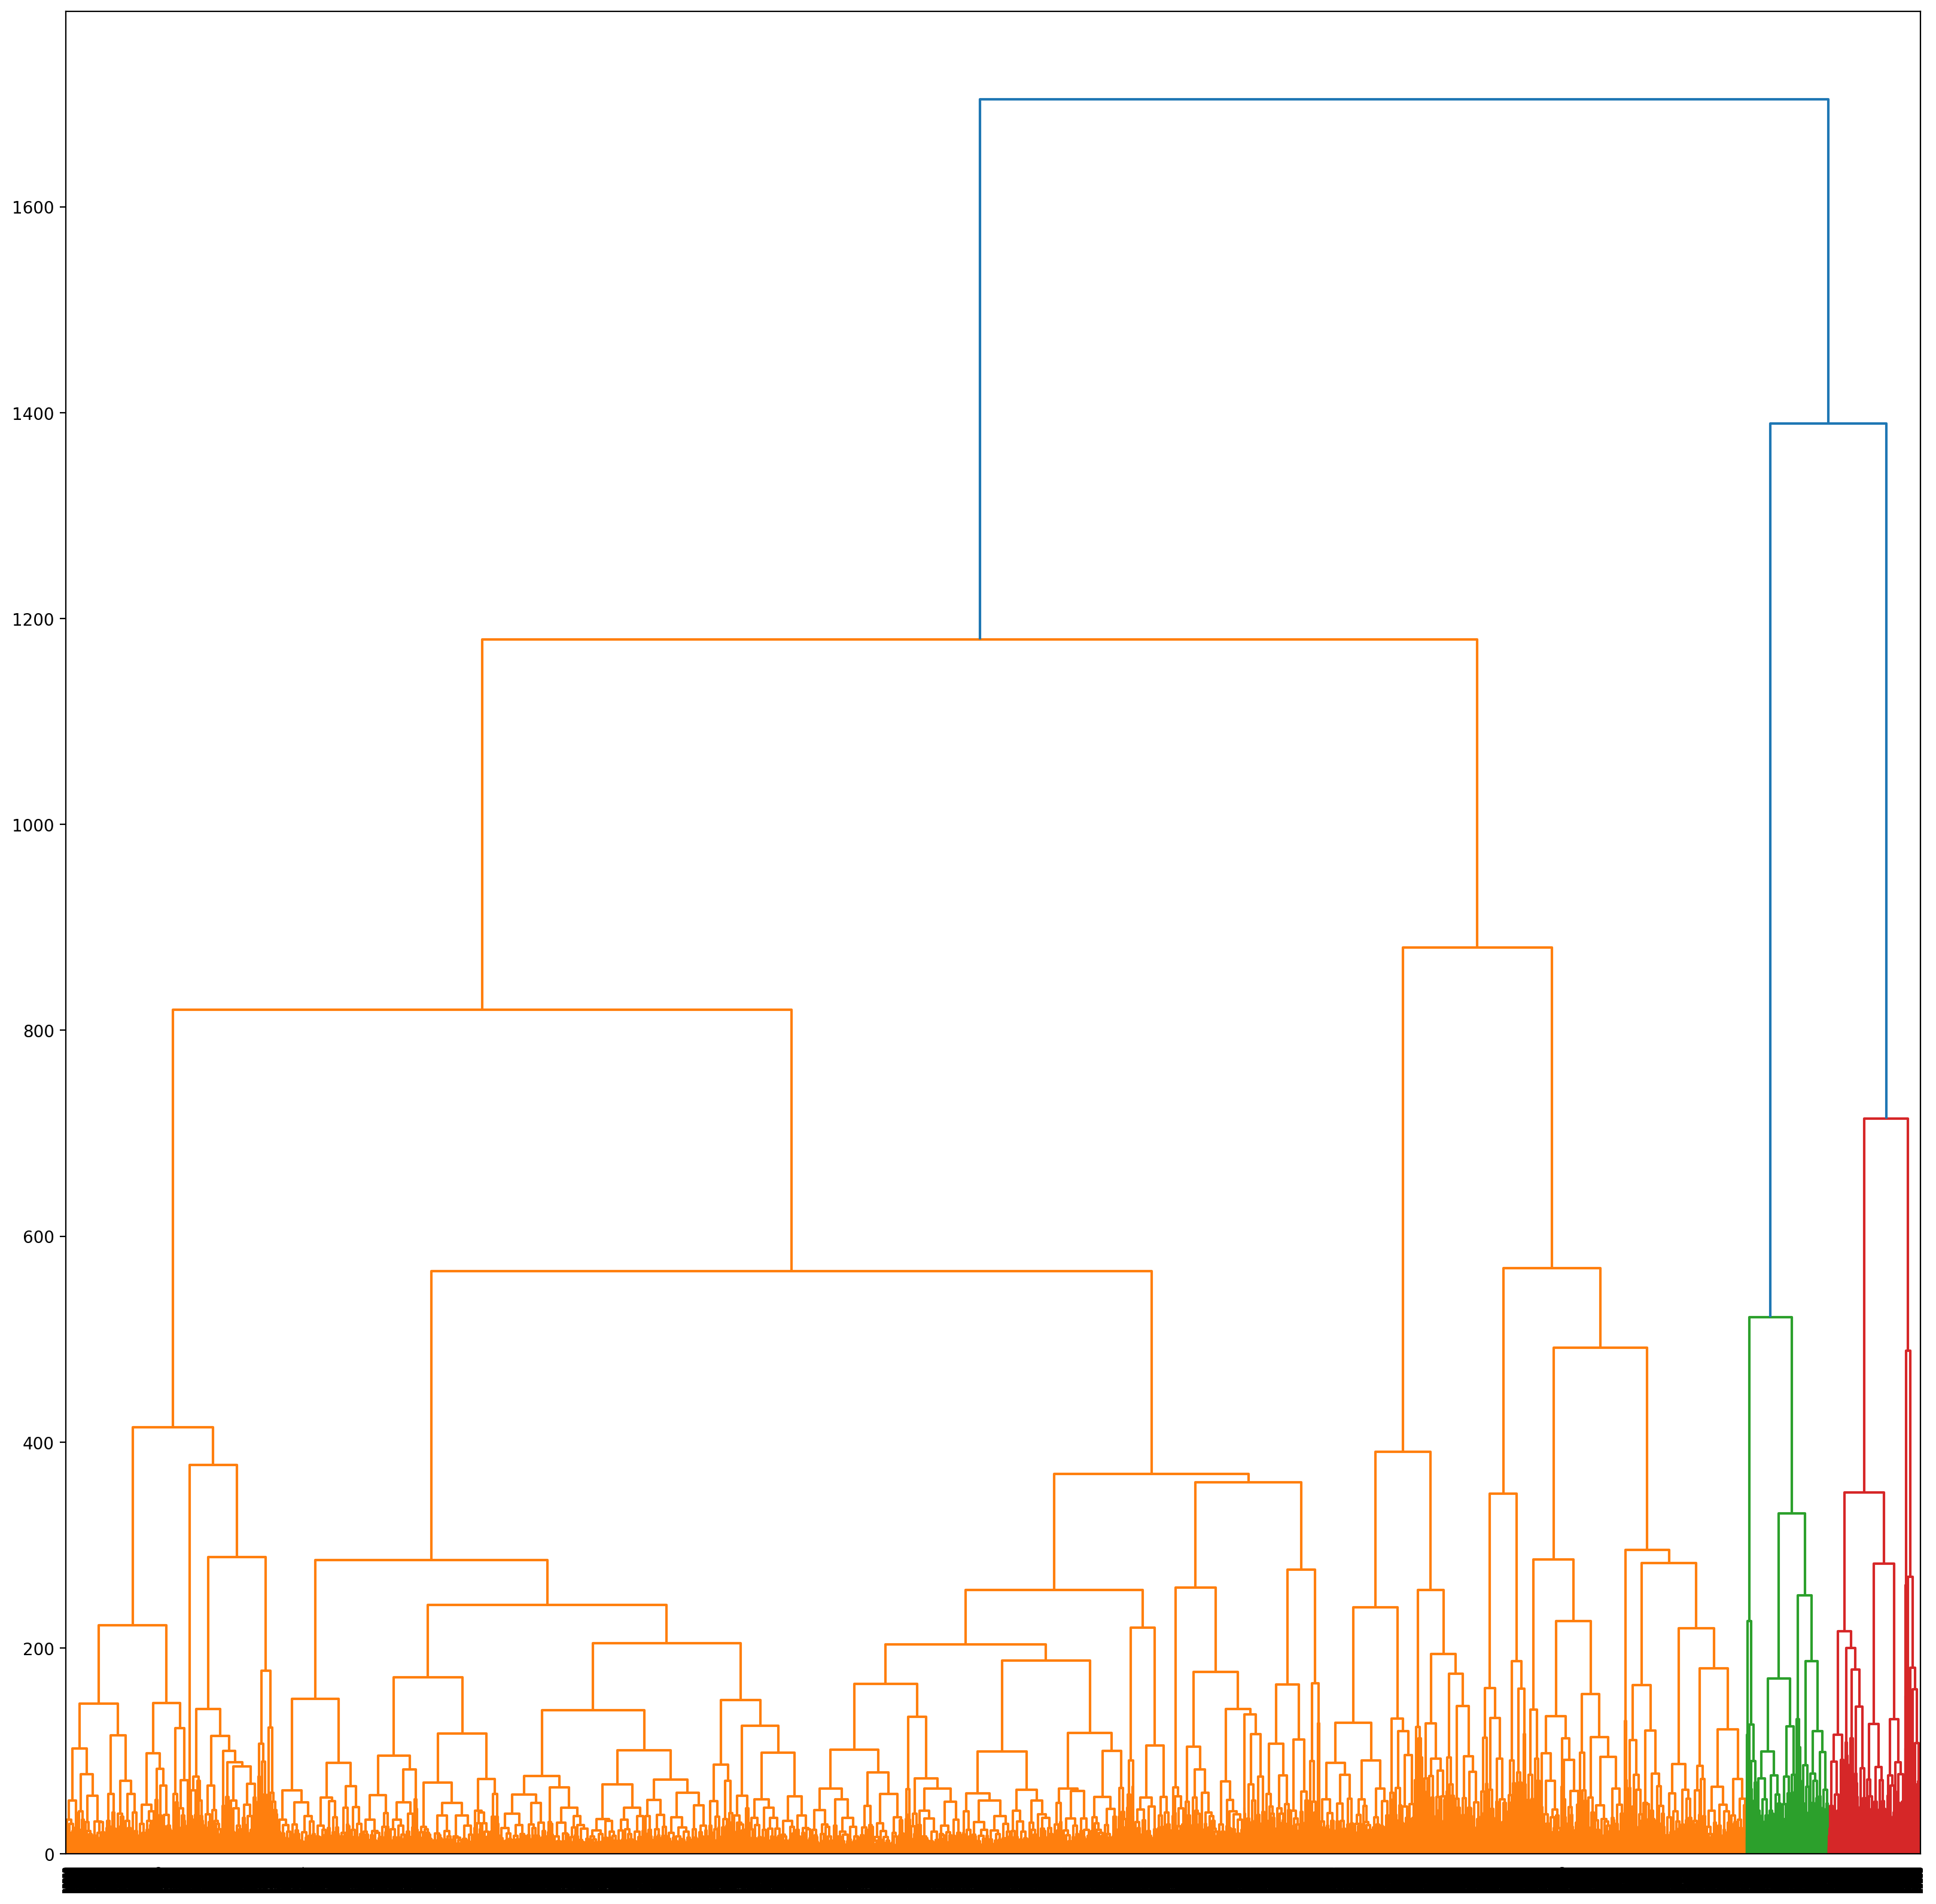

In [264]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix,ax=ax)

In [154]:
regional_ward_morphotopes_data

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,licBAD,misBAD,midBAD
10019_1,2.313985,1.744726,-0.123378,-0.294660,0.332199,-0.772219,0.125060,-0.420294,1.730121,0.870793,...,-0.126758,0.393692,0.268217,0.658013,2.706534,2.706534,3.955176,4.363062,5.196104,5.674097
10019_10,0.672821,1.301229,-0.103042,-0.941155,0.234436,1.676082,-0.554522,-0.705610,1.157440,1.414580,...,-0.098503,-2.451679,-1.433481,3.173213,1.593156,1.593156,0.027744,-0.085323,-0.045117,-0.040322
10019_11,-0.032050,0.156812,-0.123378,0.553344,-1.018317,-0.081512,0.668626,0.223935,0.310181,-0.313991,...,-1.625628,-2.722788,-1.941125,4.251944,1.320710,1.320710,-0.339334,-0.242575,-0.014622,-0.236708
10019_12,-0.406655,-0.437366,-0.117424,-0.187002,-1.089573,-0.265522,0.744934,-0.596649,-0.175318,-0.454830,...,-0.746604,-0.292668,-0.702279,-0.039953,-0.517089,-0.517089,-0.128348,-0.092823,-0.073266,-0.049373
10019_13,-0.450272,-0.426126,-0.122052,0.012213,-0.755261,0.357811,0.479861,-0.068625,-0.305345,-0.331732,...,-0.056564,-1.132923,-0.827250,0.604403,-0.262909,-0.262909,-0.386085,-0.337226,-0.330503,-0.357654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99886_95,0.572010,0.314626,-0.116874,0.373963,-0.458055,0.742485,0.910418,-0.141458,0.451495,-0.145230,...,0.045923,0.698350,0.635547,-0.246485,0.064956,0.064956,2.046449,2.812715,2.220137,2.902989
99886_96,0.961841,1.510683,-0.116874,0.217752,-0.913017,1.211188,1.239653,-0.821836,1.400979,-0.437174,...,-0.115399,0.400190,0.605551,0.263700,1.596226,1.596226,0.982718,0.714579,1.213764,1.405956
99886_97,0.876302,1.842299,0.633871,-1.355414,-0.105572,0.138239,-0.066552,-1.781769,2.273135,0.496201,...,-0.632538,-0.449246,-0.659647,0.978527,2.694024,2.694024,0.360854,0.445625,0.413128,0.557231
99886_98,0.542773,1.919666,-0.085685,-1.739661,2.076294,0.406745,-1.688832,-1.584960,1.750032,1.997425,...,-0.950223,-1.344197,-1.384694,1.647928,2.491893,2.491893,0.097609,0.057917,0.067262,0.098090


In [405]:
final_cutoff = 600

In [406]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

2    37039
4     9488
1     7547
3     5724
5     2910
6     2728
7      525
Name: count, dtype: int64

### Plotting

In [407]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [408]:
region_id = 5883

In [409]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [410]:
## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)


In [411]:
# can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [412]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [413]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 188 ms, sys: 26 ms, total: 214 ms
Wall time: 213 ms


In [414]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [415]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [284]:
etcs.final.value_counts()

final
 3     160147
 4     110202
-1      88406
 1      19931
 5      13758
 2      13527
 8      11732
 7       9824
 10      5084
 11      2290
 6       1785
 9        184
 13       173
Name: count, dtype: int64

In [403]:
target_cluster = 33
etcs[etcs.final == target_cluster].shape

(3791, 9)

In [404]:
etcs[etcs.final == target_cluster].explore(prefer_canvas=True, tiles='Cartodb positron')